c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on: cuda:0
[CropTime(min=0, max=1000000.0), ToFrame(sensor_size=(700, 1, 1), time_window=None, event_count=None, n_time_bins=50, n_event_bins=None, overlap=0, include_incomplete=False)]

[INFO] Delays: tensor([0])

[INFO] Delays i: tensor([0])

[INFO] Delays h: tensor([0])

[INFO] Delays o: tensor([0])
Delta t: 20.0 ms
mean of normal: -0.541324854612918
[0, 1, 2, 3, 4]


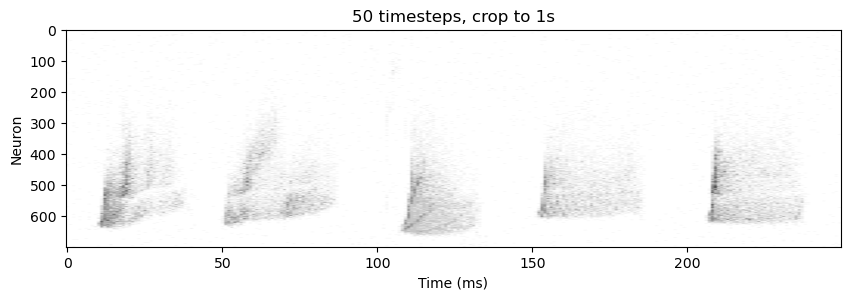

[0, 1, 2, 3, 4]


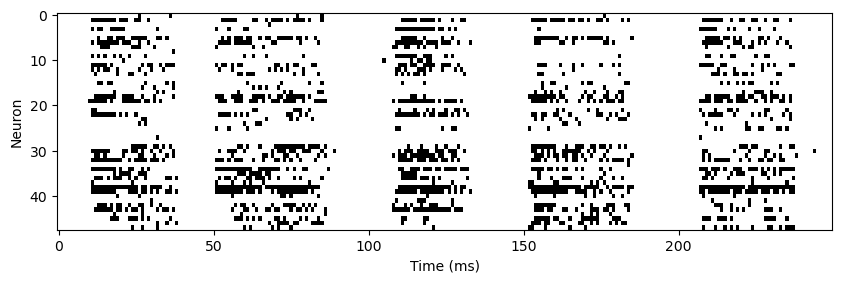

[0, 1, 2, 3, 4]


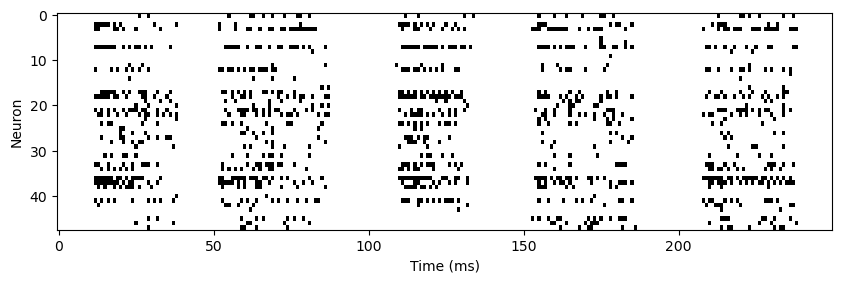

In [1]:
'''
Check if default pytorch initialization makes sense: The distribution of firing rates should be centered at half total timesteps
for different datasets and total timesteps. It this is not fulfilled, create a method to make this happen.
'''

import torch
import time
from snn_delays.snn import SNN
from snn_delays.utils.dataset_loader import DatasetLoader
from snn_delays.utils.train_utils import train, get_device, print_spike_info, propagate_batch, set_seed, copy_snn
from snn_delays.utils.visualization_utils import plot_raster
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Subset, DataLoader
from collections import OrderedDict
device = get_device()

# for reproducibility
set_seed(42)

dataset = 'shd'
total_time = 50
batch_size = 1024

# DATASET
DL = DatasetLoader(dataset=dataset,
                  caching='memory',
                  num_workers=0,
                  batch_size=batch_size,
                  total_time=total_time,
                  crop_to=1e6)

#### get the indexes for class 0,1, ... 19

train_dataset = DL._dataset.test_dataset
num_classes = DL._dataset.n_classes

class_indices = {}
for idx, (_, label) in enumerate(train_dataset):
    label = np.argmax(label)
    if label not in class_indices:
        class_indices[label] = []
    class_indices[label].append(idx)
    if len(class_indices) == num_classes:
        break
class_indices = dict(sorted(class_indices.items()))
sampled_indices = [np.random.choice(indices) for indices in class_indices.values()]

train_loader, test_loader, dataset_dict = DL.get_dataloaders()

subset = Subset(DL._dataset.test_dataset, sampled_indices)
dataloader = DataLoader(subset, batch_size=len(sampled_indices), shuffle=False)

hidden_size = 48

snn = SNN(dataset_dict=dataset_dict, structure=(hidden_size, 2), connection_type='f',
    delay=None, delay_type='ho', tau_m = 'normal',
    win=total_time, loss_fn='mem_sum', batch_size=batch_size, device=device,
    debug=True)

snn.input2spike_th = None

_, __ = propagate_batch(snn, dataloader)

plt.figure(figsize=(10,17))
plt.title(f"{total_time} timesteps, crop to 1s")
plot_raster(snn, 'input', 5)
plt.gca().set_aspect(0.1*total_time/50)
plt.show()

plt.figure(figsize=(10,17))
plot_raster(snn, 'f1', 5)
plt.gca().set_aspect(700*0.1*total_time/(50*hidden_size))
plt.show()

plt.figure(figsize=(10,17))
plot_raster(snn, 'f2', 5)
plt.gca().set_aspect(700*0.1*total_time/(50*hidden_size))
plt.show()

In [2]:
print_spike_info(snn, 'input')
print_spike_info(snn, 'f1')
print_spike_info(snn, 'f2')

for input layer
total spikes: 154713.0
spikes per sample: 151.0869140625
spikes per timestep: 3.02 / 700
spikes per neuron: 0.22 / 50
spike density: 8.633537946428572e-05
for f1 layer
total spikes: 6618.0
spikes per sample: 6.462890625
spikes per timestep: 0.13 / 48
spikes per neuron: 0.13 / 50
spike density: 5.3857421875000004e-05
for f2 layer
total spikes: 4080.0
spikes per sample: 3.984375
spikes per timestep: 0.08 / 48
spikes per neuron: 0.08 / 50
spike density: 3.3203124999999996e-05


In [3]:
snn2 = copy_snn(snn)
snn2.input2spike_th = None

_, __ = propagate_batch(snn2, dataloader)
print_spike_info(snn2, 'input')
print_spike_info(snn2, 'f1')
print_spike_info(snn2, 'f2')

print('AFTER WEIGHT SCALING')

scaling_factor = 1

from snn_delays.utils.hw_aware_utils import scale_weights
scale_weights(snn2.f0_f1, scaling_factor)
scale_weights(snn2.f1_f2, scaling_factor)
scale_weights(snn2.f2_o, scaling_factor)
_, __ = propagate_batch(snn2, dataloader)
print_spike_info(snn2, 'input')
print_spike_info(snn2, 'f1')
print_spike_info(snn2, 'f2')


[INFO] Delays: tensor([0])

[INFO] Delays i: tensor([0])

[INFO] Delays h: tensor([0])

[INFO] Delays o: tensor([0])
Delta t: 20.0 ms
mean of normal: -0.541324854612918
for input layer
total spikes: 154713.0
spikes per sample: 151.0869140625
spikes per timestep: 3.02 / 700
spikes per neuron: 0.22 / 50
spike density: 8.633537946428572e-05
for f1 layer
total spikes: 6618.0
spikes per sample: 6.462890625
spikes per timestep: 0.13 / 48
spikes per neuron: 0.13 / 50
spike density: 5.3857421875000004e-05
for f2 layer
total spikes: 4080.0
spikes per sample: 3.984375
spikes per timestep: 0.08 / 48
spikes per neuron: 0.08 / 50
spike density: 3.3203124999999996e-05
AFTER WEIGHT SCALING
for input layer
total spikes: 154713.0
spikes per sample: 151.0869140625
spikes per timestep: 3.02 / 700
spikes per neuron: 0.22 / 50
spike density: 8.633537946428572e-05
for f1 layer
total spikes: 6618.0
spikes per sample: 6.462890625
spikes per timestep: 0.13 / 48
spikes per neuron: 0.13 / 50
spike density: 5.38

[0, 1, 2, 3, 4]


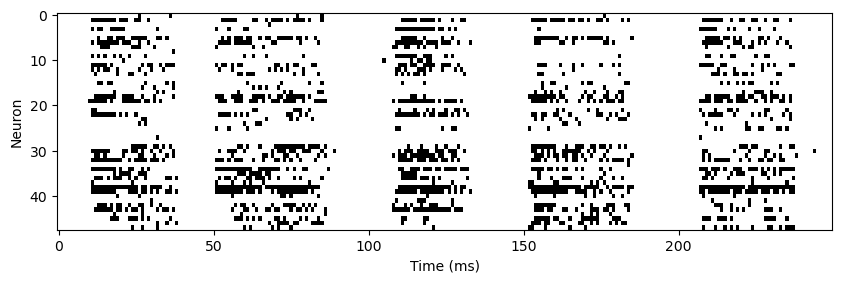

[0, 1, 2, 3, 4]


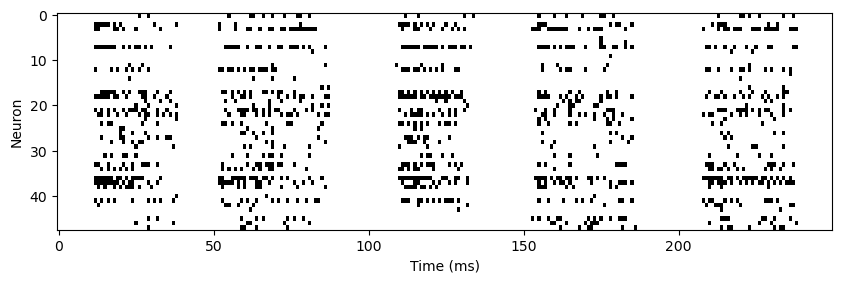

In [4]:
plt.figure(figsize=(10,17))
plot_raster(snn2, 'f1', 5)
plt.gca().set_aspect(700*0.1*total_time/(50*hidden_size))
plt.show()

plt.figure(figsize=(10,17))
plot_raster(snn2, 'f2', 5)
plt.gca().set_aspect(700*0.1*total_time/(50*hidden_size))
plt.show()

Training. Usually it would be 
83-84%\
spikes: [11.62171488515901, 13.736969964664311]


In [6]:
from snn_delays.utils.test_behavior import tb_save_max_last_acc
num_epochs = 50
ckpt_dir = 'weight_init'
snn.to(device)
lr = 5e-4
train(snn, train_loader, test_loader, lr, num_epochs, dropout=0.0, lr_scale_tau=20.0, 
    test_behavior=tb_save_max_last_acc, ckpt_dir=ckpt_dir, scheduler=(100, 0.95), test_every=1)

training shd50_SNN_l2_1d1.t7 for 50 epochs...
Epoch [1/50], learning_rates 0.000500, 0.010000


c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Step [2/7], Loss: 3.68641
l1_score: 0
Step [4/7], Loss: 3.65651
l1_score: 0
Step [6/7], Loss: 3.01856
l1_score: 0
Step [8/7], Loss: 3.06929
l1_score: 0
Time elasped: 3.106994390487671
Test Loss: 4.655473351478577
Avg spk_count per neuron for all 50 time-steps 3.2782294750213623
Avg spk per neuron per layer [7.900618212804356, 5.212299414321306]
Test Accuracy of the model on the test samples: 4.284

Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\weight_init
Gradient norm for 'tau_m_1': 0.0001
Gradient norm for 'tau_m_2': 0.0006
Gradient norm for 'tau_m_o': 0.0329
Gradient norm for 'f0_f1.weight': 0.0553
Gradient norm for 'f1_f2.weight': 0.1012
Gradient norm for 'f2_o.weight': 0.4722
saving max acc: 4.284452296819788
Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\weight_init
Epoch [2/50], learning_rates 0.000500, 0.010000
Step [2/7], Loss: 3.06332
l1_score: 0
Step [4/7], Loss: 3.07029
l1_score: 0
Step [

KeyboardInterrupt: 